In [1]:
#Trend plot
#plots created by Robin Uhrich
#modified by Lilli DIederichs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl
import pandas as pd
import datetime
import matplotlib


#Tueplots
from scipy.stats import linregress
import matplotlib.colors as mcolors
from tueplots import cycler, markers,figsizes, fonts
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes

#Legend
import matplotlib.lines as mlines

In [2]:
#Plotting Params

plt.rcParams.update(figsizes.icml2022_full())
tue_plot_colors = palettes.tue_plot
from studies.utils.setup_pyplot import (
    SIDEEFFECTS_setup_tueplot,
    SIDEEFFECTS_choose_color_palette,
)
#Font
SIDEEFFECTS_setup_tueplot()
tue_plot_colors = palettes.tue_plot
FIG_SAVE_BASE_PATH = '../docs/report/fig/'

In [3]:
#Import dataset
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
    feature=Feature.PRECIPITATION
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
    feature=Feature.PRECIPITATION
)

In [4]:
merge_1 = dataset_model_1.get_merge()
merge_2 = dataset_model_2.get_merge()


N_BOOT = 10000
boot_mean = np.empty((N_BOOT, 2))
for i in tqdm(range(N_BOOT)):
    boot_mean[i, 0] = np.random.choice(np.abs(merge_1["precipitation_error"].values), replace=True, size=len(merge_1)).std()
    boot_mean[i, 1] = np.random.choice(np.abs(merge_2["precipitation_error"].values / 3), replace=True, size=len(merge_1)).std()

boot_mean.mean(axis=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:48<00:00, 206.53it/s]


array([0.36672388, 0.30073752])

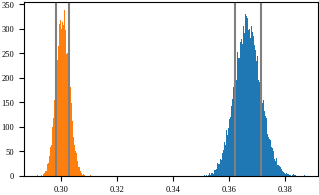

In [5]:
plt.hist(boot_mean[:, 0], bins=100)
plt.hist(boot_mean[:, 1], bins=100)
boot_mean.mean(axis=0)

plt.axvline(boot_mean.mean(axis=0)[0] - boot_mean.std(axis=0)[0], color="grey")
plt.axvline(boot_mean.mean(axis=0)[0] + boot_mean.std(axis=0)[0], color="grey")

plt.axvline(boot_mean.mean(axis=0)[1] - boot_mean.std(axis=0)[1], color="grey")
plt.axvline(boot_mean.mean(axis=0)[1] + boot_mean.std(axis=0)[1], color="grey")

In [6]:
merge_1 = dataset_model_1.get_merge().copy()
merge_2 = dataset_model_2.get_merge().copy()

# absolute values
# merge_1["precipitation_error"] = merge_1["precipitation_error"].abs()
# merge_2["precipitation_error"] = merge_2["precipitation_error"].abs()

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge_2["call_time"] = merge_2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge_2["time"] - merge_2["call_time"]
merge_2.insert(len(merge_2.columns), "time_delta", time_delta)


N_BOOT = 10000

time_delta_std_1 = np.empty((len(merge_1["time_delta"].unique()), N_BOOT, 2))
for idx, (_, group) in enumerate(tqdm(merge_1.groupby("time_delta"))):
    for i in range(N_BOOT):
        time_delta_std_1[idx, i, 0] = np.random.choice(group["precipitation_error"].values, replace=True, size=len(group)).std()
        time_delta_std_1[idx, i, 1] = np.random.choice(np.abs(group["precipitation_error"].values), replace=True, size=len(group)).std()

time_delta_std_2 = np.empty((len(merge_2["time_delta"].unique()), N_BOOT, 2))
for idx, (_, group) in enumerate(tqdm(merge_2.groupby("time_delta"))):
    for i in range(N_BOOT):
        time_delta_std_2[idx, i, 0] = np.random.choice(group["precipitation_error"].values / 3, replace=True, size=len(group)).std()
        time_delta_std_2[idx, i, 1] = np.random.choice(np.abs(group["precipitation_error"].values / 3), replace=True, size=len(group)).std()


  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 56/56 [01:22<00:00,  1.47s/it]


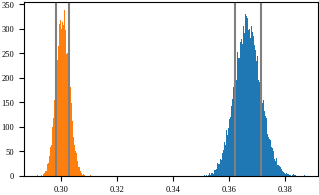

In [7]:
plt.hist(boot_mean[:, 0], bins=100)
plt.hist(boot_mean[:, 1], bins=100)
boot_mean.mean(axis=0)

plt.axvline(boot_mean.mean(axis=0)[0] - boot_mean.std(axis=0)[0], color="grey")
plt.axvline(boot_mean.mean(axis=0)[0] + boot_mean.std(axis=0)[0], color="grey")

plt.axvline(boot_mean.mean(axis=0)[1] - boot_mean.std(axis=0)[1], color="grey")
plt.axvline(boot_mean.mean(axis=0)[1] + boot_mean.std(axis=0)[1], color="grey")

forecast 1 mean:  0.005080804183813443
forecast 2 mean:  0.023185350529100528
forecast 1 mean:  0.1529267403978052
forecast 2 mean:  0.15936994782480893


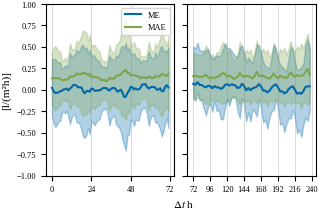

In [8]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

ax1.grid(axis='x', color='gray',linewidth = 0.5, alpha=0.4)
ax2.grid(axis='x', color='gray',linewidth = 0.5, alpha=0.4)

# plot means
mean_time_delta = merge_1.groupby("time_delta").mean().iloc[:-1]
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c=tue_plot_colors[3], label="ME")
print("forecast 1 mean: ", (mean_time_delta["precipitation_error"]).mean())
ax1.fill_between(
    t,
    mean_time_delta["precipitation_error"] - time_delta_std_1.mean(axis=1)[:-1, 0],
    mean_time_delta["precipitation_error"] + time_delta_std_1.mean(axis=1)[:-1, 0],
    alpha=0.3,
    color=tue_plot_colors[3]
)

mean_time_delta = merge2.groupby("time_delta").mean()
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c=tue_plot_colors[3], label="MAE")
print("forecast 2 mean: ", (mean_time_delta["precipitation_error"] / 3).mean())
ax2.fill_between(
    t,
    mean_time_delta["precipitation_error"] - time_delta_std_2.mean(axis=1)[:, 0],
    mean_time_delta["precipitation_error"] + time_delta_std_2.mean(axis=1)[:, 0],
    alpha=0.3,
    color=tue_plot_colors[3]
)


# absolute values
merge_1["precipitation_error"] = merge_1["precipitation_error"].abs()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()

# plot means
mean_time_delta = merge_1.groupby("time_delta").mean().iloc[:-1]
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c=tue_plot_colors[5], label="MAE")
print("forecast 1 mean: ", (mean_time_delta["precipitation_error"]).mean())
ax1.fill_between(
    t,
    mean_time_delta["precipitation_error"] - time_delta_std_1.mean(axis=1)[:-1, 1],
    mean_time_delta["precipitation_error"] + time_delta_std_1.mean(axis=1)[:-1, 1],
    alpha=0.3,
    color=tue_plot_colors[5]
)


mean_time_delta = merge2.groupby("time_delta").mean()
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c=tue_plot_colors[5], label="mean")
print("forecast 2 mean: ", (mean_time_delta["precipitation_error"] / 3).mean())
ax2.fill_between(
    t,
    mean_time_delta["precipitation_error"] / 3 - time_delta_std_2.mean(axis=1)[:, 1],
    mean_time_delta["precipitation_error"] / 3 + time_delta_std_2.mean(axis=1)[:, 1],
    alpha=0.3,
    color=tue_plot_colors[5]
)



ax1.set_ylabel('[l/(m²h)]')
#ax1.set_title("Model 1")
ax1.set_xlabel(""   "")
ax2.set_xlabel(""   "")
ax1.set_xticks(np.linspace(0, 72, 4, dtype=int), np.linspace(0, 72, 4, dtype=int))

ax1.set_ylim((-1, 1))
ax1.legend()

#ax2.set_title("Model 2")
fig.text(0.54,-0.05,"$\Delta t$ h")
ax2.set_xticks(
    np.linspace(0, 56, 8, dtype=int) * 3 + 72, np.linspace(0, 56, 8, dtype=int) * 3 + 72
)



plt.savefig(os.path.join(FIG_SAVE_BASE_PATH,'fig_mean.pdf'))